# 📘 Introducción

## ¿Qué es el polipropileno?

El **polipropileno (PP)** es un polímero termoplástico perteneciente a la familia de las poliolefinas. Se obtiene mediante la **polimerización del propileno**, un derivado del petróleo.  
Es uno de los plásticos más utilizados a nivel mundial debido a su bajo costo, versatilidad, ligereza y resistencia química.

Entre sus principales aplicaciones destacan:

- Empaques y envases  
- Industria automotriz  
- Textiles y fibras  
- Construcción  
- Dispositivos médicos  
- Productos del hogar  

Su combinación de precio accesible, resistencia y facilidad de moldeo lo convierten en un material indispensable en la manufactura moderna.

---

## ¿Por qué su precio es relevante?

El precio del polipropileno es un indicador económico importante, pues está influenciado por factores interconectados como:

- Precios del petróleo y gas natural  
- Oferta y demanda global  
- Situación de la industria petroquímica  
- Políticas comerciales y condiciones macroeconómicas  
- Paros técnicos o fallas en plantas de producción  

Su relevancia se debe a que el PP afecta directamente los **costos de producción** de múltiples industrias.  
Por ello, contar con **predicciones confiables del precio del PP** ayuda a:

- Planificar compras y presupuestos  
- Evaluar riesgos de precios  
- Estimar márgenes  
- Realizar análisis económicos de mercado  

---

## Breve revisión del dataset

Los datos fueron obtenidos mediante un método de scraping controlado desde TradingEconomics, tomando los valores históricos del precio spot del polipropileno.

El dataset contiene dos columnas principales:

- **Date** — Fecha de registro  
- **Price** — Precio del polipropileno por tonelada  

Ejemplo de datos:

| Date       | Price |
|------------|-------|
| 2024-11-20 | 7489  |
| 2024-11-21 | 7510  |
| 2024-11-22 | 7504  |
| 2024-11-25 | 7467  |
| 2024-11-26 | 7479  |

Características del dataset:

- Frecuencia: **Diaria**  
- Formato: **serie temporal**  
- Moneda: **USD por tonelada**  
- Datos limpios y sin valores nulos  
- Ordenados de forma cronológica  



---


In [138]:
#importar datos desde tampermokey
import pandas as pd
import requests

df = pd.DataFrame(requests.get("http://localhost:8765/pp").json())

df = df.rename(columns={"date": "Date", "value": "Price"})
df["Date"] = pd.to_datetime(df["Date"])
df.head()


ConnectionError: HTTPConnectionPool(host='localhost', port=8765): Max retries exceeded with url: /pp (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x326ea5880>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [162]:
#imortar datos desde csv
import pandas as pd
from pandas import read_csv 
df = pd.DataFrame(read_csv("commodity_data.csv"))

df = df.rename(columns={"date": "Date", "value": "Price"})
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.asfreq('D')
df['Price'] = df['Price'].ffill()


df.head()

,Price
Date,
2024-11-21,7510.0
2024-11-22,7504.0
2024-11-23,7504.0
2024-11-24,7504.0
2024-11-25,7467.0


In [163]:
import pandas as pd
import plotly.express as px



fig = px.line(
    df_plot,
    x="Date",
    y="Price",
    title="Precio del Polipropileno (PP) — Histórico",
    markers=True
)

fig.update_layout(
    xaxis_title="Fecha",
    yaxis_title="Precio (CNY/T)",
    hovermode="x unified",
    template="plotly_dark",
    title_font=dict(size=22),
    height=500
)



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Date=%{x}<br>Price=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines+markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array(['2024-11-21T00:00:00.000000000', '2024-11-22T00:00:00.000000000',
                          '2024-11-23T00:00:00.000000000', ..., '2025-11-18T00:00:00.000000000',
                          '2025-11-19T00:00:00.000000000', '2025-11-20T00:00:00.000000000'],
                         shape=(365,), dtype='datetime64[ns]'),
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAABWvUAAAAAAAFC9QAAAAAAAUL' ... 'AAG7lAAAAAAAAWuUAAAAAAAPy4QA=='),
                    'dtype': 'f8'},
              'yaxis': 'y'}],
    'layout': {'height': 500,
               'hovermode': 'x unified',
               'legend': {'tracegroupgap': 0},
               'template': '...',
               'title': {'font': {'size': 22}, 'text': 'Precio del Polipropileno (PP) — Histórico'},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'Fecha'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'Precio (CNY/T)'}}}
})

In [164]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["Price_scaled"] = scaler.fit_transform(df[["Price"]])
df.head()


,Price,Price_scaled
Date,,
2024-11-21,7510.0,1.000000
2024-11-22,7504.0,0.994614
2024-11-23,7504.0,0.994614
2024-11-24,7504.0,0.994614
2024-11-25,7467.0,0.961400


In [165]:
import numpy as np

data = df["Price_scaled"].values

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data  = data[train_size:]


In [166]:
def create_windows(series, window_size=30):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)


In [167]:
WINDOW = 30  # puedes cambiarlo después

X_train, y_train = create_windows(train_data, WINDOW)
X_test,  y_test  = create_windows(test_data,  WINDOW)

# Ajustar dimensiones para LSTM/CNN
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape


((262, 30, 1), (43, 30, 1))

# LTSM



In [168]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
# 1. Importar EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

model1 = Sequential([
    # Asegúrate de que 'WINDOW' esté definido previamente en tu código
    LSTM(64, return_sequences=True, input_shape=(WINDOW, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model1.compile(optimizer="adam", loss="mse")
model1.summary()

# 2. Configurar el Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',       
    patience=10,             
    restore_best_weights=True 
)

# 3. Añadirlo al entrenamiento con 'callbacks'
history = model1.fit(
    X_train, y_train,
    epochs=100,               
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],   
    verbose=1
)

/Users/maxaguayo/Documents/modelos-no-lineales/cnn-Ltsm_prediccion_Polipropileno/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3784 - val_loss: 0.0536
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0480 - val_loss: 0.0365
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0235 - val_loss: 0.0237
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0186 - val_loss: 0.0491
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - val_loss: 0.0424
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - val_loss: 0.0320
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - val_loss: 0.0399
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0129 - val_loss: 0.0329
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - val_loss: 0.0353
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - val_loss: 0.0333
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111 - val_loss: 0.0300
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - val_loss: 0.0322


In [169]:
from tensorflow.keras.models import Sequential
# Aquí añadimos 'Input' que era lo que faltaba, además de las capas de CNN
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- MODELO CNN 1D ---
model2 = Sequential([
    # Definimos la entrada explícitamente
    Input(shape=(X_train.shape[1], X_train.shape[2])), 
    
    # 1. Capa Convolucional: Busca patrones locales
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    
    # 2. Capa de Pooling: Reduce dimensionalidad
    MaxPooling1D(pool_size=2),
    
    # 3. Segunda Convolución
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    
    # 4. GlobalAveragePooling en lugar de Flatten (mejor para evitar overfitting)
    GlobalAveragePooling1D(), 
    
    Dropout(0.3),
    
    # 5. Capas densas finales
    Dense(16, activation='relu'),
    Dense(1)
])

model2.compile(optimizer='adam', loss='huber')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

print("Entrenando CNN...")
history = model2.fit(
    X_train, y_train,
    epochs=200, 
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Entrenando CNN...
Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0761 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0137 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0089 - val_loss: 0.0185 - learning_rate: 0.0010
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0092 - val_loss: 0.0219 - learning_rate: 0.0010
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0094 - val_loss: 0.0224 - learning_rate: 0.0010
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065 - val_loss: 0.0204 - learning_rate: 0.0010
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0245 - learning_rate: 0.0010
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0063 - val_loss: 0.0246 - learning_rate: 5.0000e-

## MSE y MAPE

📊 Calculando métricas...

🏆 RESULTADOS FINALES
🔹 Model 1 (LSTM):
   MSE:  29352.62
   MAPE: 2.3790%  <-- Error porcentual promedio
----------------------------------------
🔸 Model 2 (CNN):
   MSE:  46032.18
   MAPE: 3.1445%  <-- Error porcentual promedio
✅ El ganador es: LSTM (Model 1) (Mejor por 0.7655%)


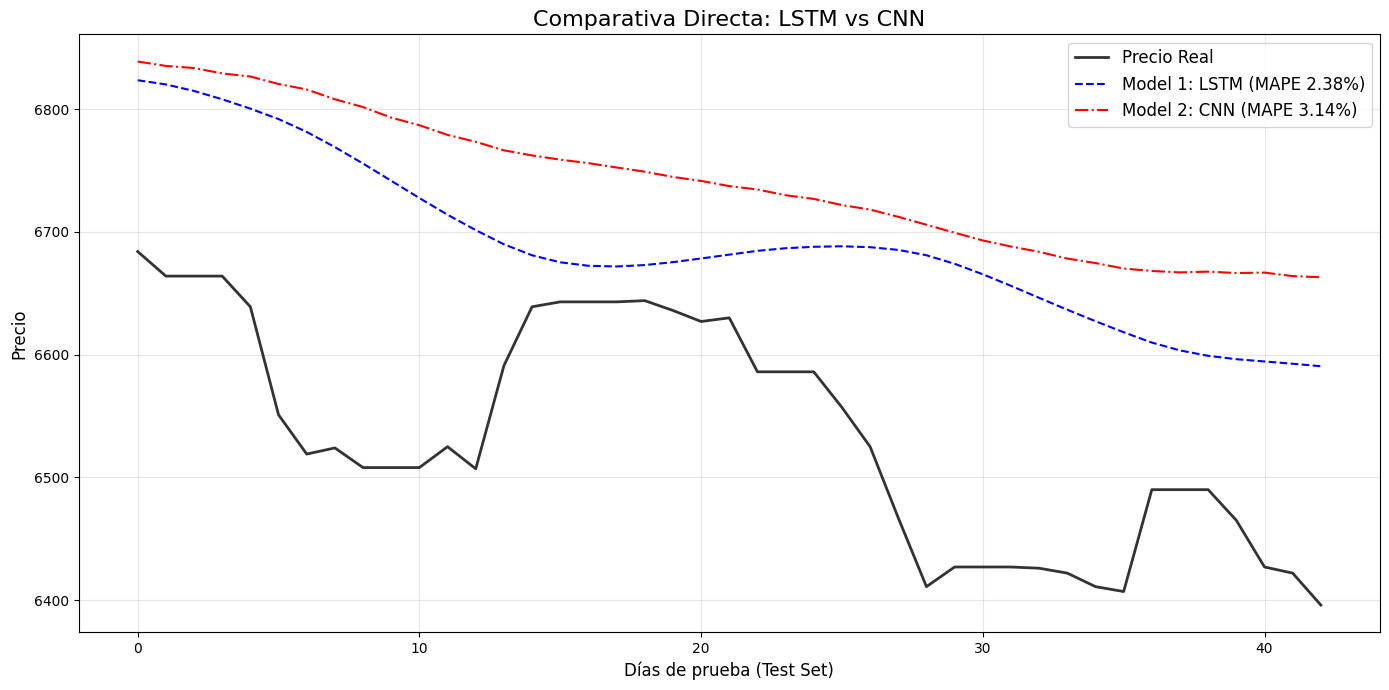

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# --- Función para evaluar manejando el des-escalado ---
def evaluar_modelo(model, X_test, y_test, scaler, nombre):
    # 1. Predecir
    # El modelo devuelve valores entre 0 y 1
    pred_scaled = model.predict(X_test, verbose=0)
    
    # 2. Preparar matrices para invertir la escala (Inverse Transform)
    # El scaler espera (filas, n_features), así que creamos una matriz 'dummy'
    # y rellenamos solo la primera columna con nuestros datos de precio.
    n_features = scaler.n_features_in_
    
    # -- Des-escalar Predicción --
    dummy_pred = np.zeros((len(pred_scaled), n_features))
    dummy_pred[:, 0] = pred_scaled.flatten()
    y_pred_real = scaler.inverse_transform(dummy_pred)[:, 0]
    
    # -- Des-escalar Real (y_test) --
    dummy_true = np.zeros((len(y_test), n_features))
    dummy_true[:, 0] = y_test.flatten()
    y_true_real = scaler.inverse_transform(dummy_true)[:, 0]
    
    # 3. Calcular Métricas
    mse = mean_squared_error(y_true_real, y_pred_real)
    mape = mean_absolute_percentage_error(y_true_real, y_pred_real) * 100
    
    return mse, mape, y_pred_real, y_true_real

# --- EJECUCIÓN PARA TUS DOS MODELOS ---

print("📊 Calculando métricas...")

# 1. Evaluar LSTM (model1)
mse1, mape1, pred1, y_real = evaluar_modelo(model1, X_test, y_test, scaler, "LSTM")

# 2. Evaluar CNN (model2)
# Usamos el mismo y_real devuelto arriba, no hace falta recalcularlo
mse2, mape2, pred2, _ = evaluar_modelo(model2, X_test, y_test, scaler, "CNN")

# --- MOSTRAR RESULTADOS ---

print("\n" + "="*40)
print(f"🏆 RESULTADOS FINALES")
print("="*40)
print(f"🔹 Model 1 (LSTM):")
print(f"   MSE:  {mse1:.2f}")
print(f"   MAPE: {mape1:.4f}%  <-- Error porcentual promedio")
print("-" * 40)
print(f"🔸 Model 2 (CNN):")
print(f"   MSE:  {mse2:.2f}")
print(f"   MAPE: {mape2:.4f}%  <-- Error porcentual promedio")
print("="*40)

# Decidir ganador
ganador = "LSTM (Model 1)" if mape1 < mape2 else "CNN (Model 2)"
diferencia = abs(mape1 - mape2)
print(f"✅ El ganador es: {ganador} (Mejor por {diferencia:.4f}%)")


# --- GRÁFICO COMPARATIVO ---
plt.figure(figsize=(14, 7))

# Datos reales
plt.plot(y_real, label='Precio Real', color='black', linewidth=2, alpha=0.8)

# Predicciones LSTM
plt.plot(pred1, label=f'Model 1: LSTM (MAPE {mape1:.2f}%)', 
         color='blue', linestyle='--', linewidth=1.5)

# Predicciones CNN
plt.plot(pred2, label=f'Model 2: CNN (MAPE {mape2:.2f}%)', 
         color='red', linestyle='-.', linewidth=1.5)

plt.title("Comparativa Directa: LSTM vs CNN", fontsize=16)
plt.xlabel("Días de prueba (Test Set)", fontsize=12)
plt.ylabel("Precio", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Predicciones 7 días

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN ---
n_future = 7
features = ['Price'] # Solo estamos usando Price

# Detectar automáticamente si Date es columna o índice
if "Date" in df.columns:
    last_date = df["Date"].iloc[-1]
else:
    last_date = df.index[-1]

future_dates = pd.date_range(last_date, periods=n_future+1, freq="D")[1:]

# --- 2. PREPARAR LA ÚLTIMA VENTANA (Univariante) ---
# Tomamos solo la columna Price
last_window_data = df[features].tail(WINDOW).values 
# Escalamos (asegúrate de que 'scaler' fue entrenado solo con Price también)
last_window_scaled = scaler.transform(last_window_data)

# --- 3. FUNCIÓN DE PREDICCIÓN (Lógica Simplificada) ---
def predecir_univariante(model, initial_window, steps):
    # Damos forma (1, window_size, 1)
    current_batch = initial_window.reshape(1, WINDOW, 1)
    predictions = []
    
    for _ in range(steps):
        # Predecir el siguiente punto
        pred_val = model.predict(current_batch, verbose=0)[0][0]
        predictions.append(pred_val)
        
        # Actualizar ventana: Quitamos el primero y añadimos la predicción al final
        # En univariante es simple: solo añadimos el valor predicho
        new_entry = np.array([[[pred_val]]]) 
        current_batch = np.append(current_batch[:, 1:, :], new_entry, axis=1)
        
    return predictions

# --- 4. EJECUTAR PREDICCIONES ---
print("🔮 Generando predicciones futuras (Solo Precio)...")

# Predicciones escaladas
preds_1 = predecir_univariante(model1, last_window_scaled, n_future) # LSTM
preds_2 = predecir_univariante(model2, last_window_scaled, n_future) # CNN

# --- 5. INVERTIR ESCALA ---
# Como el scaler es univariante, es directo
future_real_1 = scaler.inverse_transform(np.array(preds_1).reshape(-1, 1)).flatten()
future_real_2 = scaler.inverse_transform(np.array(preds_2).reshape(-1, 1)).flatten()

# --- 6. RESULTADOS Y GRÁFICO ---
df_futuro = pd.DataFrame({
    "Fecha": future_dates,
    "LSTM ($)": future_real_1,
    "CNN ($)": future_real_2,
    "Promedio": (future_real_1 + future_real_2) / 2
})

print("\n--- Pronóstico a 7 días ---")
print(df_futuro)

# Gráfico
plt.figure(figsize=(10, 6))
# Graficar últimos 30 días reales
last_30 = df.iloc[-30:]
x_hist = last_30["Date"] if "Date" in last_30.columns else last_30.index

plt.plot(x_hist, last_30["Price"], label="Histórico", color="black")
plt.plot(df_futuro["Fecha"], df_futuro["LSTM ($)"], label="LSTM", linestyle='--')
plt.plot(df_futuro["Fecha"], df_futuro["CNN ($)"], label="CNN", linestyle='-.')
plt.plot(df_futuro["Fecha"], df_futuro["Promedio"], label="Promedio", color='green', linewidth=2, alpha=0.5)

plt.title(f"Proyección Futura: LSTM vs CNN (Univariante)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

NameError: name 'window' is not defined

## Visualización próximas

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df["Price"],
    mode="lines",
    name="Histórico"
))

fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_real,
    mode="lines+markers",
    name="Predicción futura"
))

fig.update_layout(
    title="Predicción de los próximos 7 días",
    xaxis_title="Fecha",
    yaxis_title="Precio",
    template="plotly_dark"
)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'mode': 'lines',
              'name': 'Histórico',
              'type': 'scatter',
              'x': array(['2024-11-21T00:00:00.000000000', '2024-11-22T00:00:00.000000000',
                          '2024-11-23T00:00:00.000000000', ..., '2025-11-18T00:00:00.000000000',
                          '2025-11-19T00:00:00.000000000', '2025-11-20T00:00:00.000000000'],
                         shape=(365,), dtype='datetime64[ns]'),
              'y': {'bdata': ('AAAAAABWvUAAAAAAAFC9QAAAAAAAUL' ... 'AAG7lAAAAAAAAWuUAAAAAAAPy4QA=='),
                    'dtype': 'f8'}},
             {'mode': 'lines+markers',
              'name': 'Predicción futura',
              'type': 'scatter',
              'x': array(['2025-11-21T00:00:00.000000000', '2025-11-22T00:00:00.000000000',
                          '2025-11-23T00:00:00.000000000', '2025-11-24T00:00:00.000000000',
                          '2025-11-25T00:00:00.000000000', '2025-11-26T00:00:00.000000000',
                          '2025-11-27T00:00:00.000000000'], dtype='datetime64[ns]'),
              'y': {'bdata': '4evPRSv6z0VdCNBFDA3QRekV0EW4E9BF1BvQRQ==', 'dtype': 'f4'}}],
    'layout': {'template': '...',
               'title': {'text': 'Predicción de los próximos 7 días'},
               'xaxis': {'title': {'text': 'Fecha'}},
               'yaxis': {'title': {'text': 'Precio'}}}
})

## Predicciones

In [ ]:
future_table = pd.DataFrame({
    "Fecha futura": ["2025-11-24", "2025-11-25", "2025-11-26", "2025-11-27", "2025-11-28"],
    "Predicción ($/ton)": future_real[:5]
})

future_table


,Fecha futura,Predicción ($/ton)
0,2025-11-24,6653.484863
1,2025-11-25,6655.270996
2,2025-11-26,6657.045410
3,2025-11-27,6657.630859
4,2025-11-28,6658.738770


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D

# ... (Mantén todo el código de carga de datos, ingeniería de características y escalado igual) ...

# --- MODELO CNN 1D ---
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), # (Window, Features)
    
    # 1. Capa Convolucional: Busca patrones locales de 3 días
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    
    # 2. Capa de Pooling: Reduce el ruido, quedándose con la característica más fuerte
    MaxPooling1D(pool_size=2),
    
    # 3. Segunda Convolución (Opcional, para patrones más complejos)
    Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
    
    # 4. Aplanar para conectar con capas densas
    # GlobalAveragePooling1D es mejor que Flatten para evitar overfitting en datos pequeños
    GlobalAveragePooling1D(), 
    
    Dropout(0.3),
    
    # 5. Capa final de decisión
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='huber') # Huber sigue siendo excelente aquí

# Entrenamos (verás que es mucho más rápido)
history = model.fit(
    X_train, y_train,
    epochs=200, # Las CNN necesitan más epochs a veces, pero son rapidísimas
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1864 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0131 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0095 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0318 - learning_rate: 5.0000e-04
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0116 - val_loss: 0.0377 - learning_rate: 5.0000e-04
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0106 - val_loss: 0.0320 - learning_rate: 5.0000e-04
Epoch 1